In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing as scale
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
input_file = ["Backdoor.csv" , "DDoS_HTTP.csv" , "DDoS_ICMP.csv" , "DDoS_TCP.csv" , "DDoS_UDP.csv"  , "Password.csv" , "Port_Scanning.csv" ,"Ransomware.csv", "SQL_injection.csv" , "Uploading.csv" , "Vulnerability_scanner.csv" ,"XSS.csv" ]

In [4]:
def pred(x, clfs, p_nodes, gms):
    p_x_node = np.zeros((len(x), len(clfs))) # p[x, in node i] = p(x | x in Node i) * p(x in Node i)
    p_y_given_node = np.zeros((len(x), len(clfs))) # p[y | x, node i]
    for i in tqdm(range(len(clfs))):
        p_x_node[:, i] = p_nodes[i] * np.exp(gms[i].score_samples(x))
        p_y_given_node[:, i] = clfs[i].predict_proba(x)[:, 1]
    
    p_y = p_y_given_node * p_x_node / (np.sum(p_x_node, axis=-1, keepdims=True) + 1e-10)

    p_y = np.hstack([1-np.sum(p_y, axis=-1, keepdims=True), p_y])

    return np.argmax(p_y, axis=-1)

In [17]:
columns_to_drop_bi = ['Attack_type','Attack_label']

data_list = []
for i in range(len(input_file)):
    data = pd.read_csv(input_file[i])
    data.drop(columns = columns_to_drop_bi, inplace = True)
    data_list.append(data)



In [18]:
rs = 42 # set the random state

In [20]:
from sklearn.svm import SVC
clfs = [] # This is going to contain 14 different classifiers
n_samples = []
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []
y = [np.ones(len(data_list[i])) * (i + 1) for i in range(len(data_list))]
for i in tqdm(range(len(input_file))): # reading the data
    data0 = pd.read_csv(input_file[i])
    y[i][data0.Attack_type =="Normal"] = 0
    n_samples.append(len(y[i])) # the number of this node
    x = data_list[i]
    x_train, x_test, y_train, y_test = train_test_split(x, y[i], test_size = 0.25, random_state = rs)
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)
x_train_full = pd.concat(x_train_list, ignore_index=True)
scaler = scale.StandardScaler().fit(x_train_full)

for i in range(len(input_file)):
    x_train_list[i] = scaler.transform(x_train_list[i])
    classifier =  KNeighborsClassifier()
    classifier.fit(x_train_list[i], y_train_list[i])
    clfs.append(classifier)

total_n_samples = np.sum(n_samples)
print('total number is ',total_n_samples)
p_nodes =  np.array(n_samples) / total_n_samples
print('The proportion of the nodes are:', p_nodes)




total number is  155169
The proportion of the nodes are: [0.07765726 0.08044133 0.10732814 0.07805038 0.11043443 0.07608478
 0.07670991 0.08321894 0.07854017 0.07821794 0.07674858 0.07656813]


In [21]:
from sklearn.mixture import GaussianMixture
gms = []
K = 15 # The number of the components of the GMM, one could change it by analyzing the graph
for i in tqdm(range(len(input_file))):
    gm = GaussianMixture(n_components = K).fit(x_train_list[i])  
    gms.append(gm)

In [22]:
for i in range(len(input_file)):
    x_test_list[i] = scaler.transform(x_test_list[i])

In [23]:
x_test = np.vstack(x_test_list)
y_test = np.hstack(y_test_list)
x_train = np.vstack(x_train_list)
y_train = np.hstack(y_train_list)

prediction = pred(x_test, clfs, p_nodes, gms)

In [24]:
correct = prediction == y_test
accuracy = np.mean(correct)
print('Overall accuracy is:', accuracy)

Overall accuracy is: 0.5752616114232693


In [25]:
recalls = []
for i in range(len(input_file)+1):
    if len(correct[y_test==i]) == 0:
        recalls.append(0)
    else:
        recalls.append(np.mean(correct[y_test==i]))
print('Recalls:', recalls)
precisions = []
for i in range(len(input_file)+1):
    if len(correct[prediction==i]) == 0:
        precisions.append(0)
    else:
        precisions.append(np.mean(correct[prediction==i]))
print('Precision:', precisions)

Recalls: [0.5035684647302905, 0.684748427672956, 0.5862462006079028, 0.9997157475838545, 0.5918686473807663, 0.9997241379310344, 0.1384430176565008, 0.9662564509726081, 0.07610294117647058, 0.6848249027237354, 0.134375, 0.7699325664418881, 0.1249005568814638]
Precision: [0.7521070897372335, 0.5635716596570689, 0.4088500264970853, 1.0, 0.8990498812351544, 1.0, 0.5066079295154186, 0.6106372303060712, 0.43125, 0.16632016632016633, 0.864321608040201, 0.9613670133729569, 0.33836206896551724]


Centralized:

In [27]:
classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)


KNeighborsClassifier()

In [28]:
# pred_full = classifier.predict(X_test)
pred_full = classifier.predict(x_test)
# correct_full = pred_full == Y_test
correct_full = pred_full == y_test
accuracy_full = np.mean(correct_full)
print('Overall accuracy is:', accuracy_full)
accs_full = []
for i in range(len(input_file)+1):
    if len(correct[y_test==i]) == 0:
        accs_full.append(0)
    else:
        accs_full.append(np.mean(correct_full[y_test==i]))
print('Recalls:', accs_full)
recalls_full = []
for i in range(len(input_file)+1):
    if len(correct_full[pred_full==i]) == 0:
        recalls_full.append(0)
    else:
        recalls_full.append(np.mean(correct_full[pred_full==i]))
print('Precisions:', recalls_full)

Overall accuracy is: 0.6463219753595546
Recalls: [0.6946058091286307, 0.9300314465408805, 0.46200607902735563, 0.9997157475838545, 0.7978889757623143, 0.9997241379310344, 0.24077046548956663, 0.6383485510123065, 0.7878676470588235, 0.24941634241245136, 0.23671875, 0.7786592621975407, 0.2251392203659507]
Precisions: [0.5088145896656535, 0.6723500994600738, 0.46877409406322285, 1.0, 0.729188996070025, 1.0, 0.27347310847766637, 0.7175368139223561, 0.8818930041152263, 0.33472584856396864, 0.3441226575809199, 0.8802690582959641, 0.32361349342481416]


Balancing the data

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
columns_to_drop_bi = ['Attack_type']

data_list = []
for i in range(len(input_file)):
    data = pd.read_csv(input_file[i])
    data['attack_type'] = i + 1
    data.loc[data.Attack_type == 'Normal', 'attack_type'] = 0
    data.drop(columns = columns_to_drop_bi, inplace = True)
    if len(data) < 2000:
        data_list.append(data)
    else:
        data0 = data[data['attack_type'].isin([0])]
        x1 = data0.sample(n = 1000, random_state = i + 42, axis = 0)
        data1 = data[data['attack_type'].isin([i+1])]
        x2 = data1.sample(n = 1000, random_state = i + 43, axis = 0)   
        data_selected = pd.concat([x1, x2], ignore_index=True)  
        data_list.append(data_selected) 
for i in range(len(data_list)):
    print(len(data_list[i]))  


rs = 42 # set the random state

clfs = [] # This is going to contain 14 different classifiers
n_samples = []
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []
y = [np.ones(len(data_list[i])) * (i + 1) for i in range(len(data_list))]
for i in tqdm(range(len(input_file))): # reading the data
    data0 = data_list[i]
    y[i][data0.attack_type == 0] = 0
    n_samples.append(len(y[i])) # the number of this node
    x = data_list[i]
    x = x.drop(columns=['attack_type' , 'Attack_label'])
    x_train, x_test, y_train, y_test = train_test_split(x, y[i], test_size = 0.25, random_state = rs)
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)

x_train_full = pd.concat(x_train_list, ignore_index=True)
scaler = scale.StandardScaler().fit(x_train_full)

for i in range(len(input_file)):
    x_train_list[i] = scaler.transform(x_train_list[i])

for i in tqdm(range(len(input_file))):
    classifier = KNeighborsClassifier()
    classifier.fit(x_train_list[i], y_train_list[i])
    clfs.append(classifier)

total_n_samples = np.sum(n_samples)
print('total number is ',total_n_samples)
p_nodes =  np.array(n_samples) / total_n_samples
print('The proportion of the nodes are:', p_nodes)

for i in range(len(input_file)):
    x_test_list[i] = scaler.transform(x_test_list[i])

x_test = np.vstack(x_test_list)
y_test = np.hstack(y_test_list)
x_train = np.vstack(x_train_list)
y_train = np.hstack(y_train_list)

# GMM
from sklearn.mixture import GaussianMixture
gms = []
K = 18 # The number of the components of the GMM, one could change it by analyzing the graph
for i in tqdm(range(len(input_file))):
    x = x_train_list[i]
    gm = GaussianMixture(n_components = K).fit(x)  
    gms.append(gm)

prediction_b = pred(x_test, clfs, p_nodes, gms)

correct_b = prediction_b == y_test

accs_b = []
for i in range(len(input_file)+1):
    if len(correct_b[y_test==i]) == 0:
        accs_b.append(0)
    else:
        accs_b.append(np.mean(correct_b[y_test==i]))
print('Accuracies:', accs_b)
recalls_b = []
for i in range(len(input_file)+1):
    if len(correct_b[prediction_b==i]) == 0:
        recalls_b.append(0)
    else:
        recalls_b.append(np.mean(correct_b[prediction_b==i]))
print('Recalls:', recalls_b)

classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)

# pred_full = classifier.predict(X_test)
pred_full_b = classifier.predict(x_test)
# correct_full = pred_full == Y_test
correct_full_b = pred_full_b == y_test
accuracy_full_b = np.mean(correct_full_b)
print('Overall accuracy is:', accuracy_full_b)
accs_full_b = []
for i in range(len(input_file)+1):
    if len(correct_b[y_test==i]) == 0:
        accs_full_b.append(0)
    else:
        accs_full_b.append(np.mean(correct_full_b[y_test==i]))
print('Recalls:', accs_full_b)
recalls_full_b = []
for i in range(len(input_file)+1):
    if len(correct_full_b[pred_full_b==i]) == 0:
        recalls_full_b.append(0)
    else:
        recalls_full_b.append(np.mean(correct_full_b[pred_full_b==i]))
print('Precisions:', recalls_full_b)


2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000



total number is  24000
The proportion of the nodes are: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]



Accuracies: [0.9189364461738002, 0.3786008230452675, 0.32098765432098764, 0.9958847736625515, 0.8106995884773662, 1.0, 0.11522633744855967, 0.7325102880658436, 0.3868312757201646, 0.08641975308641975, 0.11522633744855967, 0.7818930041152263, 0.16049382716049382]
Recalls: [0.7300360638845955, 0.8440366972477065, 0.38613861386138615, 1.0, 0.7163636363636363, 1.0, 0.8, 0.6691729323308271, 0.6527777777777778, 0.45652173913043476, 0.6363636363636364, 0.9359605911330049, 0.1262135922330097]
Overall accuracy is: 0.727
Recalls: [0.9228274967574579, 0.7860082304526749, 0.27983539094650206, 0.9958847736625515, 0.8024691358024691, 0.9876543209876543, 0.09465020576131687, 0.6460905349794238, 0.6213991769547325, 0.10699588477366255, 0.13991769547325103, 0.7654320987654321, 0.012345679012345678]
Precisions: [0.7595409661062184, 0.49226804123711343, 0.4358974358974359, 0.9877551020408163, 0.7014388489208633, 1.0, 0.25842696629213485, 0.7235023041474654, 0.6771300448430493, 0.36619718309859156, 0.336

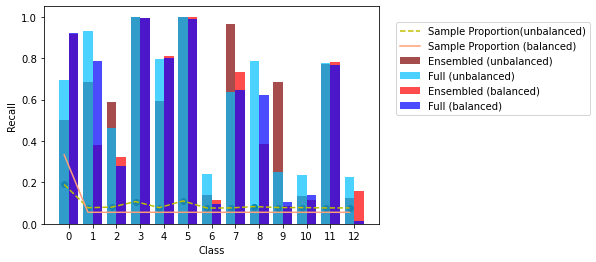

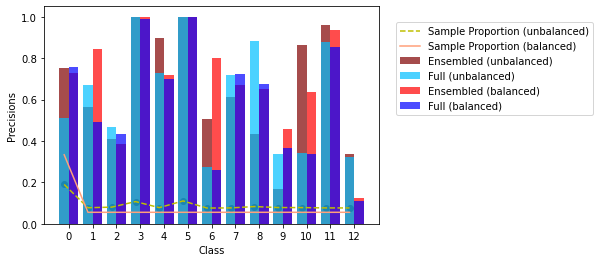

In [30]:
p_balanced = [12000]
p_balanced += n_samples
p_balanced /= np.sum(p_balanced)
p_labels =[0.19,0.07765726, 0.08044133, 0.10732814, 0.07805038, 0.11043443, 0.07608478,
 0.07670991, 0.08321894, 0.07854017, 0.07821794, 0.07674858, 0.07656813]
fig,ax = plt.subplots()
width = 0.4
x1 = np.arange(len(input_file)+1)
ax.bar(x1, np.array(recalls),width, alpha=0.7, label='Ensembled (unbalanced)', color='maroon')
ax.bar(x1, np.array(accs_full),width, alpha=0.7, label='Full (unbalanced)', color='deepskyblue')
ax.bar(x1+width, np.array(accs_b),width, alpha=0.7, label='Ensembled (balanced)', color='r')
ax.bar(x1+width, np.array(accs_full_b),width, alpha=0.7,  label='Full (balanced)', color='b')
plt.plot(x1, p_labels, color='y', linestyle= '--',label='Sample Proportion(unbalanced)')
plt.plot(x1, p_balanced, color='lightsalmon',linestyle= '-', label='Sample Proportion (balanced)')

ax.set_xticks(x1 +width/2)#将坐标设置在指定位置

ax.set_xticklabels(x1)#将横坐标替换成
plt.scatter(x1, p_labels, color='k')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=3, borderaxespad=0)
plt.show()


fig,ax = plt.subplots()
ax.bar(x1, np.array(precisions),width, alpha=0.7, label='Ensembled (unbalanced)', color='maroon')
ax.bar(x1, np.array(recalls_full),width, alpha=0.7, label='Full (unbalanced)', color='deepskyblue')
ax.bar(x1+width, np.array(recalls_b),width, alpha=0.7, label='Ensembled (balanced)', color='r')
ax.bar(x1+width, np.array(recalls_full_b),width, alpha=0.7,  label='Full (balanced)', color='b')
plt.plot(x1, p_labels, color='y', linestyle= '--',label='Sample Proportion (unbalanced)')
plt.plot(x1, p_balanced, color='lightsalmon',linestyle= '-', label='Sample Proportion (balanced)')

ax.set_xticks(x1 +width/2)#将坐标设置在指定位置

ax.set_xticklabels(x1)#将横坐标替换成
plt.scatter(x1, p_labels, color='k')
plt.xlabel('Class')
plt.ylabel('Precisions')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=3, borderaxespad=0)
plt.show()